In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [2]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [3]:
char2int_ki = {
    "T": 0,  # ki platform
    "M": 1,  # ki movable platform
    "D": 2,  # ki door
    "#": 3,  # ki ground
    "H": 4,  # ki hazard
    "*": 5,  # for ki background, different from vglc (from Anurag's email)
    "P": 6,  # for ki path (from Anurag's email)
}
int2char = {v:k for k, v in char2int_ki.items()}

## Density

In [8]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'kia'
MODEL = 'gmvae'
num_components=10

json_fname = f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json'
num_components = int(json_fname.split('_')[-1].split('.')[0])
num_gens_per_comp = 500

In [9]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [10]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [11]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

10

In [12]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
df /= df.max()
df.columns = [int2char[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head()

,T,M,D,#,H,*
0,0.519389,0.142174,0.002764,0.089898,0.002072,0.984759
1,0.329524,0.007823,1.000000,0.007728,1.000000,0.113434
2,0.485669,0.000543,0.028801,0.416320,0.001098,0.846686
3,0.164106,0.021351,0.019929,0.582099,0.003575,0.766417
4,0.467123,0.174716,0.020508,0.308016,0.005699,0.853986


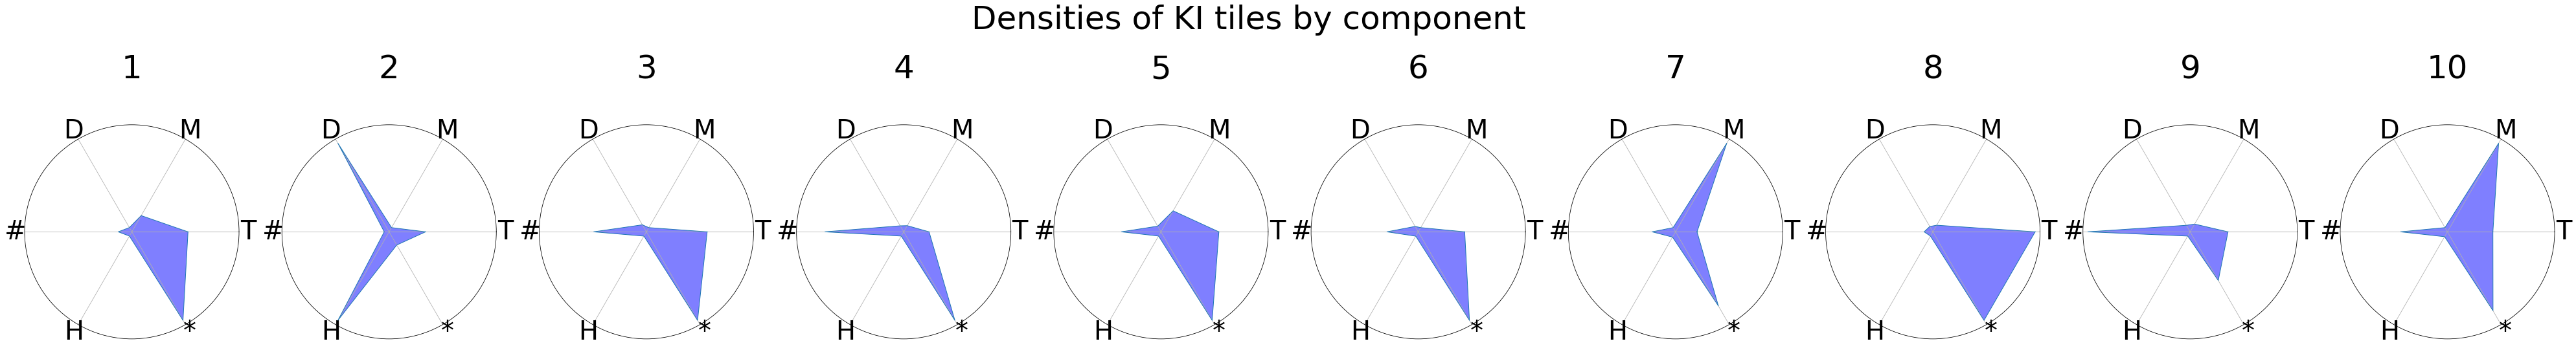

In [13]:
categories = list(df)

fig, axs = plt.subplots(nrows=1, ncols=num_components, figsize=(num_components * 7, 7),
                           subplot_kw=dict(polar=True))
axs = axs.flatten()

for i in range(num_components):
    
    ax = axs[i]
    
    values = df.iloc[i].tolist()
    values += values[:1] # repeat the first value to close the circular graph
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=40)
    ax.set_yticks([])
    ax.set_rlabel_position(30)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'blue', alpha=0.5)
    
    ax.set_title(f'{i+1}', y=1.20, fontsize=50)

plt.suptitle('Densities of KI tiles by component', y=1.20, fontsize=50)
# plt.tight_layout()
plt.show()

## Plotting generations from each component

In [14]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='kia')[0])
    return images

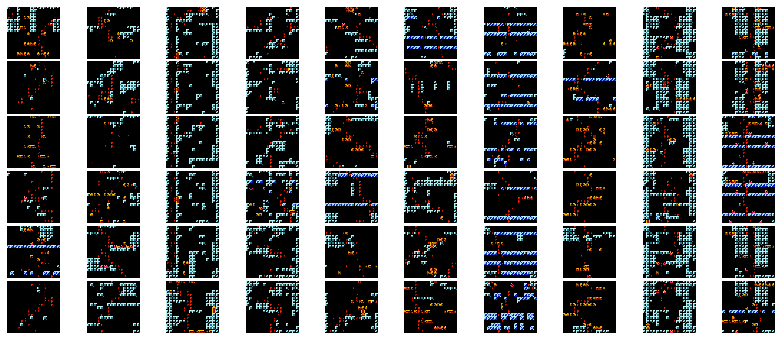

In [15]:
num_rows=6
fig, axs = plt.subplots(num_rows, num_components, figsize=(num_components+4, num_rows))
fig.subplots_adjust(hspace=0.05)
# plt.suptitle('SMB', fontsize=50, y=0.915)
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_rows])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            pass
#             ax.set_ylabel(f'{comp_idx + 1}', rotation=0, fontsize=50)
            # https://stackoverflow.com/questions/27671748/how-to-print-y-axis-label-horizontally-in-a-matplotlib-pylab-chart
#             ax.yaxis.set_label_coords(-0.5, 0.15)
            # https://stackoverflow.com/questions/37815976/setting-the-position-of-the-ylabel-in-a-matplotlib-graph
        ax = axs[img_idx][comp_idx]
#         if comp_idx == 0 and img_idx == 2:
#             ax.set_ylabel('SMB', fontsize=20)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
# plt.tight_layout()
plt.savefig(f'KI generations per component (GM-VAE {num_components}).png', dpi=600)